In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torch.utils.data import Dataset, DataLoader
from Model.dataloader import TranscriptionDataset, collate_fn
from Model.encoder_net import EncoderNet
from Model.decoder_net import DecoderNet
from train import train_transcriber
print(torch.__version__)
from tqdm import tqdm_notebook as tqdm

0.4.0


### 1. Make Sure that the Encoder/Decoder and Work

In [3]:
def train_localizer_network():
    IMAGE_DIR = '../Data/FullData/Cropped_Images/'
    ANNOTATION_PATH = '../Data/FullData/Transcriptions/annotations.npy'
    DATA_PATH = '../Data/FullData/train_dev_test.npy'
    WORD_VEC_PATH = '../Data/FullData/Transcriptions/nutrition_vectors.npy'
    INDEX_TO_TERM_PATH = '../Data/FullData/Transcriptions/index_term_dict.npy'
    TERM_TO_INDEX_PATH = '../Data/FullData/Transcriptions/term_index_dict.npy'
    PATH_TO_MEAN_IMAGE = '../Data/FullData/512_512_mean.npy' 
    debug = not torch.cuda.is_available()
    
    train_dataset = TranscriptionDataset(
        IMAGE_DIR, ANNOTATION_PATH, DATA_PATH, WORD_VEC_PATH,
        PATH_TO_MEAN_IMAGE, debug=debug, split='train'
    )
    train_loader = DataLoader( 
        train_dataset, batch_size=116, shuffle=True,
        num_workers=8, collate_fn=collate_fn
    )
    
    dev_dataset = TranscriptionDataset(
        IMAGE_DIR, ANNOTATION_PATH, DATA_PATH, WORD_VEC_PATH,
        PATH_TO_MEAN_IMAGE, debug=debug, split='dev',
    )
    dev_loader = DataLoader(
        dev_dataset, batch_size=116, shuffle=True, 
        num_workers=8, collate_fn=collate_fn
    )
    
    
    config = {
        'keep_prob': 0.9
    }
    learning_rate = 5e-3
    
    encoder = EncoderNet(config_params=config)
    word_vectors = train_dataset.get_word_vectors()
    embed_size = len(word_vectors[0])
    output_size = train_dataset.get_output_size()
    decoder = DecoderNet(word_vectors, output_size, embed_size)
    
    parameters = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, parameters), 
        lr=learning_rate, weight_decay=0.005
    )
    results = train_transcriber(
        encoder, decoder, optimizer, train_loader, dev_loader,
        train_dataset, dev_dataset, epochs=100, restore=False
    )
    return results

In [4]:
train_losses, dev_losses, train_bleu, dev_bleu = train_localizer_network()

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  4.623377323150635
	 Dev Loss =  4.360044479370117
	 Dev BLEU =  0.0009004347170597654


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

Process Process-313:
Process Process-319:
Process Process-314:
Process Process-318:
Process Process-308:
Process Process-309:
Process Process-305:
Process Process-311:
Process Process-320:
Process Process-307:
Process Process-306:
Process Process-312:
Process Process-315:
Process Process-317:
Process Process-310:
Process Process-316:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/l

  File "/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6

  File "/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._Dat

KeyboardInterrupt: 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
plt.plot(train_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()

NameError: name 'train_losses' is not defined

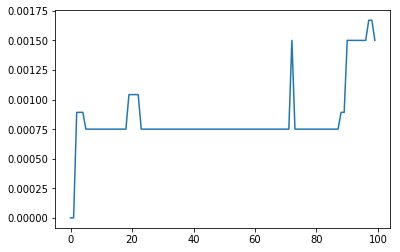

In [6]:
plt.plot(dev_bleu)

In [6]:
def ensure_all_data_is_available():
    import numpy as np
    data_path = '../Data/FullData/train_dev_test.npy'
    ANNOTATION_PATH = '../Data/FullData/Transcriptions/annotations.npy'
    annotations = np.load(ANNOTATION_PATH).item()
    images = (
            np.load(data_path).item()['train'] + np.load(data_path).item()['dev'] + 
            np.load(data_path).item()['test']
    )
    bad = []
    for img in tqdm(images):
        num = img[:img.rfind('_')]
        nut = '1_' + num; ingr = '0_'+num
        if nut not in annotations or ingr not in annotations:
            bad.append(num)
    print(set(bad))

In [8]:
# ensure_all_data_is_available()